# FRONTERA EFICIENTE

## Autor: María Carrasco Meléndez, Raquel Fort Serra y Lucía Saiz Lapique

__Práctica 4__

__Gestión de Activos y Carteras__

__CUNEF__

En el estudio a continuación, el objetivo es, con los datos estudiados anteriormente, calcular la frontera eficiente, es decir, el conjunto de las carteras más eficientes del mercado, teniendo en cuenta el mayor rendimiento posible con la menor cantidad de riesgo que supongan.

Se ha decidido llevar a cabo este estudio (y el de las estrategias a plantear) con esta herramienta (Python), pues debido al resto de trabajos ejecutados en el curso, tenemos más soltura con este lenguaje que con Excel. 

En primer lugar, cargamos las librerias necesarias y los datos recogidos después del análisis estratéico en cuestión.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import seaborn as sns

Los modelos de predicción estudiados han sido los siguientes y se introducen en este mismo orden: 
* Cross sectional momentum a diferentes horizontes de inversion.
* Contraria.
* Ranking por ratios fundamentales
* Ranking por preferencias de analistas
* Ranking por sentimientos

In [33]:
estrategia1 = pd.read_csv('Estrategia_Momentum_final.csv')
estrategia2 = pd.read_csv('Estrategia_Contraria_final.csv')
estrategia3 = pd.read_csv('Estrategia_ratios.csv')
estrategia4 = pd.read_csv('Estrategia_Recommendation_final.csv')
estrategia5 = pd.read_csv('Estrategia_Sentiment_final.csv')

In [34]:
estrategia1['Contraria'] = estrategia2['Contraria']
estrategia1['Ratios'] = estrategia3['ratios']
estrategia1['Recommendation'] = estrategia4['Recommendation']
estrategia1['Sentiment'] = estrategia5['Sentiment']
datos = estrategia1
datos.head()

,Date,Momentum,Contraria,Ratios,Recommendation,Sentiment
0,2015-01-05,100.000000,100.000000,100.000000,100.000000,100.000000
1,2015-01-06,99.540079,100.283177,99.400045,99.347409,99.568923
2,2015-01-07,100.852321,99.557614,100.795088,101.028999,100.806070
3,2015-01-08,104.388104,98.072111,105.208099,105.139176,105.667802
4,2015-01-09,102.765083,98.798819,103.158718,103.081029,103.451629


En las 5 primeras líneas de la base de datos importada, vemos las estrategias generada para cada activo en el orden en el que se han estudiado anteriormente en otros notebooks de Jupyter. Graficamos las 5 estrategias para estudiar, de forma visual, el desempeño de cada una. 

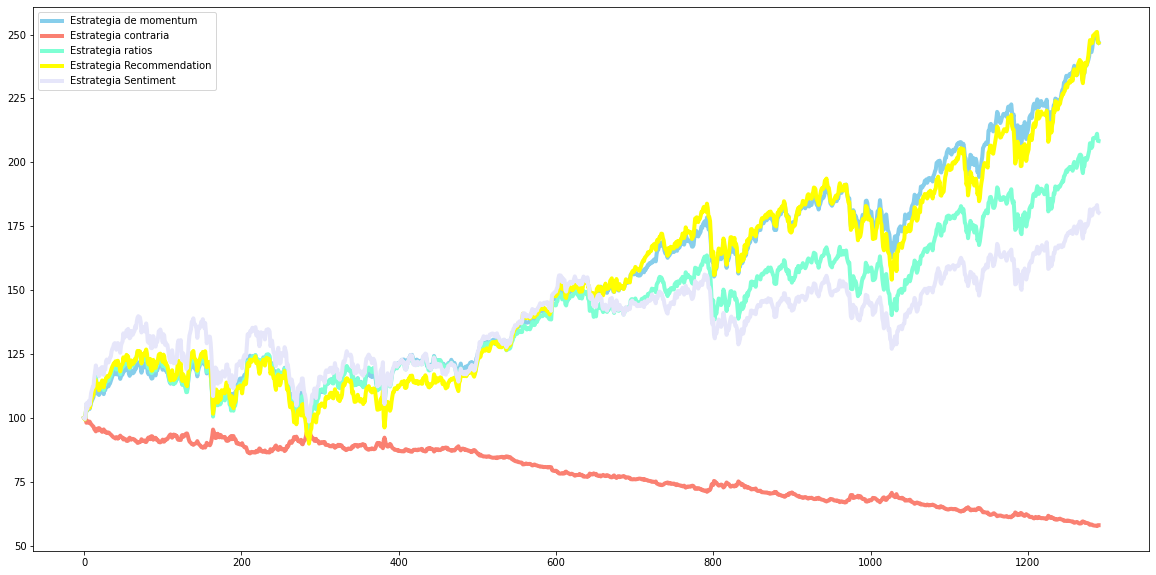

In [35]:
plt.figure(figsize=(20,10))
plt.plot(datos.index, datos['Momentum'], marker='', markerfacecolor='blue', markersize=12, color='skyblue', 
         linewidth=4, label = 'Estrategia de momentum')
plt.plot(datos.index, datos['Contraria'], marker='', markerfacecolor='salmon', markersize=12, color='salmon', 
         linewidth=4, label = 'Estrategia contraria')
plt.plot(datos.index, datos['Ratios'], marker='', markerfacecolor='aquamarine', markersize=12, color='aquamarineDar peso a cada modelo y calcular el rendimiento de la cartera agregada por modelo,
junto con su volatilidad asociadas', 
         linewidth=4, label = 'Estrategia ratios')
plt.plot(datos.index, datos['Recommendation'], marker='', markerfacecolor='yellow', markersize=12, color='yellow', 
         linewidth=4, label = 'Estrategia Recommendation')
plt.plot(datos.index, datos['Sentiment'], marker='', markerfacecolor='lavender', markersize=12, color='lavender', 
         linewidth=4, label = 'Estrategia Sentiment')
plt.legend()

Previo a la generación de la cartera óptima y basándonos únicamente en la comparación gráfica de cada estrategia, podemos concluir que:
* La única estrategia que tiene una tendencia bajista es la estrategua contraria
* La estrategia contraria, a pesar de perder valor, es la que sufre menos alteraciones y la que, por tanto, tiene menos volatilidad (es la más estable)
* Existen dos estrategias que se comportan y crecen de forma muy similar: la estrategia de momentum y la de recomendaciones de analistas. 
* Las cuatro estrategias crecientes comparten tendencia y estacionalidad muy similar, con descensos y picos en las mismas épocas, aunque de distinta intensidad.

In [38]:
datos = datos.set_index('Date')
datos.head()

,Momentum,Contraria,Ratios,Recommendation,Sentiment
Date,,,,,
2015-01-05,100.000000,100.000000,100.000000,100.000000,100.000000
2015-01-06,99.540079,100.283177,99.400045,99.347409,99.568923
2015-01-07,100.852321,99.557614,100.795088,101.028999,100.806070
2015-01-08,104.388104,98.072111,105.208099,105.139176,105.667802
2015-01-09,102.765083,98.798819,103.158718,103.081029,103.451629


## Dar peso a cada modelo

A continuación, generamos una nueva base de datos que mantenga la fecha como índice y que calcule el rendimiento diario en comparación con el día anterior para cada variable.

In [39]:
df = datos.pct_change().dropna()

In [40]:
df.tail()

,Momentum,Contraria,Ratios,Recommendation,Sentiment
Date,,,,,
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.002511,-0.001186,0.002878,0.002771,0.002161
2019-12-27,0.003500,-0.001948,0.004973,0.000584,0.004713
2019-12-30,-0.013302,0.006156,-0.013290,-0.015679,-0.015070
2019-12-31,-0.000046,-0.000033,-0.000281,-0.001364,-0.001228


Como primer parámetro que debemos introducir, consideramos que la mejor manera de seleccionar los pesos de cada estrategia es asignándole a cada acción un peso proporcional al precio que tiene cada una de ellas en el último día de los datos históricos (en este caso, los datos de cada estrategia). Por tanto, calculamos el valor mas reciente del precio total invertido por todas las estrategias y los pesos adjudicados a cada uno seria el porcentaje resultando del precio de cada accion entre el precio total de la cartera. 

In [41]:
total = datos['Momentum'][-1] + datos['Contraria'][-1] + datos['Ratios'][-1] + datos['Recommendation'][-1] + datos['Sentiment'][-1]

In [42]:
#Creamos matriz de pesos para cada activo ("Equally weighted")
weights = [datos['Momentum'][-1]/total, datos['Contraria'][-1]/total, datos['Ratios'][-1]/total,
           datos['Recommendation'][-1]/total, datos['Sentiment'][-1]/total]

A continuación generamos una cartera de base con los pesos seleccionados, donde podemos ver su rendimiento esperado según esos pesos  y los pesos activos seleccionados.

In [43]:
n_assets = len(df.columns)
w = np.array(weights)
r = np.array(np.mean(df))
C = np.cov(df.transpose())

#Validamos
print("Rendimiento esperado:", r)
print("Pesos activos:", w)

Rendimiento esperado: [ 0.00075857 -0.00041047  0.0006479   0.00079002  0.0005524 ]
Pesos activos: [0.2625042  0.06167576 0.2215855  0.26247093 0.19176361]


## Correlaciones con activos tradicionales

Generamos a continuación la matriz de correlaciones entre cada estrategia, además de un mapa de calor (heatmap), donde es posible observar estas correlaciones de forma mucho más visual.

In [44]:
cov = pd.DataFrame(C, columns = ['Momentum', 'Contraria', 'Ratios', 'Recommendation','Sentiment'])
cov.index = ['Momentum', 'Contraria', 'Ratios', 'Recommendation','Sentiment']
print('Matriz de covarianzas:')
cov

Matriz de covarianzas:


,Momentum,Contraria,Ratios,Recommendation,Sentiment
Momentum,0.000116,-0.000051,0.000131,0.000140,0.000139
Contraria,-0.000051,0.000024,-0.000059,-0.000063,-0.000064
Ratios,0.000131,-0.000059,0.000157,0.000162,0.000169
Recommendation,0.000140,-0.000063,0.000162,0.000178,0.000174
Sentiment,0.000139,-0.000064,0.000169,0.000174,0.000190


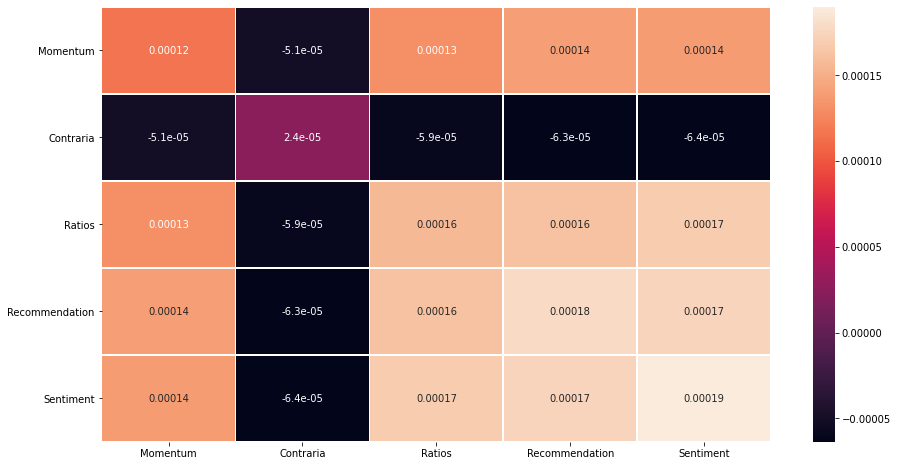

In [45]:
plt.figure(figsize = (15,8))
ax = sns.heatmap(cov, linewidth=0.8, annot = True)
plt.show()

Como podemos observar de esta matriz de correlaciones, la estrategia cross sectional contraria mantiene una correlacion negativa muy fuerte con las demás. Además, las mayores correlaciones positivas existen entre las estrategias de recomendación y de análisis de sentimiento de noticias. Curiosamente, las correlaciones son muy pequeñas, a pesar de que en la comparación gráfica se observó que las estrategias tenian un comportamiento muy similar.

## Calcular el rendimiento de la cartera agregada por modelo junto con su volatilidad asociadas

Estudiamos además la contribución del riesgo a cada estrategia y lo comparamos con su rendimiento.

In [46]:
def risk_contribution(w,C):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    port_variance = np.dot(w.T, np.dot(C, w))
    # Marginal contribution of each constituent
    marginal_contrib = C@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/port_variance
    return risk_contrib

In [47]:
risk_contrib = risk_contribution(w, C)
risk_contrib

array([ 0.24634668, -0.0260483 ,  0.24419574,  0.30668515,  0.22882072])

In [48]:
rend = w * r * 252
rend

array([ 0.05018024, -0.00637964,  0.03617862,  0.0522543 ,  0.02669459])

In [49]:
rendimiento = pd.DataFrame(rend, columns = ['Rendimiento'], index = ['Momentum', 'Contraria', 'Ratios', 'Recommendation','Sentiment'])
rendimiento['Riesgo'] = risk_contrib.tolist()
rendimiento

,Rendimiento,Riesgo
Momentum,0.050180,0.246347
Contraria,-0.006380,-0.026048
Ratios,0.036179,0.244196
Recommendation,0.052254,0.306685
Sentiment,0.026695,0.228821


En el gráfico a continuación, se puede observar una comparación del rendimiento y los riesgos de cada activo con las distintas estrategias por separado. 

Observamos que:
* Todas las estrategias tienen muchísima volatilidad en comparación con el rendimiento que aportan a excepción de la estrategia contraria
* Como hemos supuesto anteriormente, la estrategia de cross sectional contraria es la que menos volatilidad tiene (de hecho, es negativa) aunque su rendimiento también es el más bajo (rendimiento negativo)
* La estrategia más arriesgada o volátile es la de recomendación, siendo también la que mayor rentabilidad aporta.

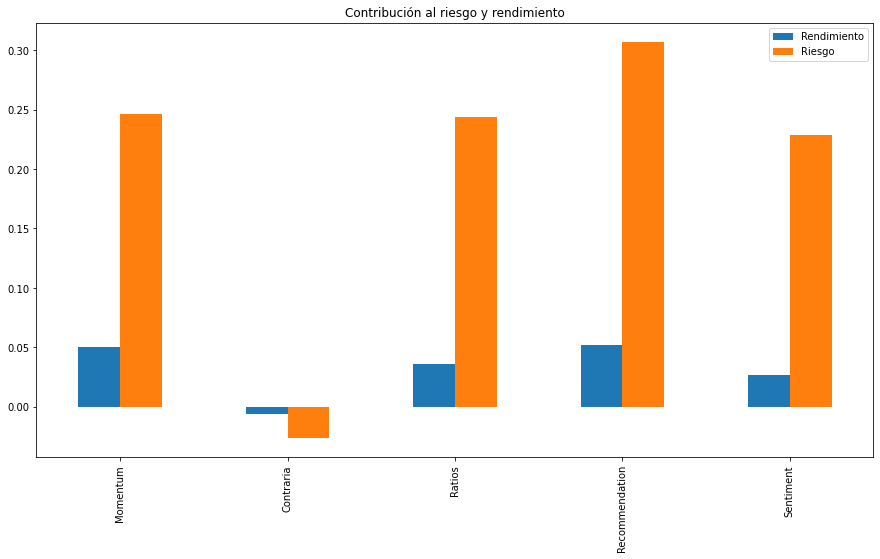

In [50]:
rendimiento.plot.bar(title = "Contribución al riesgo y rendimiento", figsize = (15, 8))

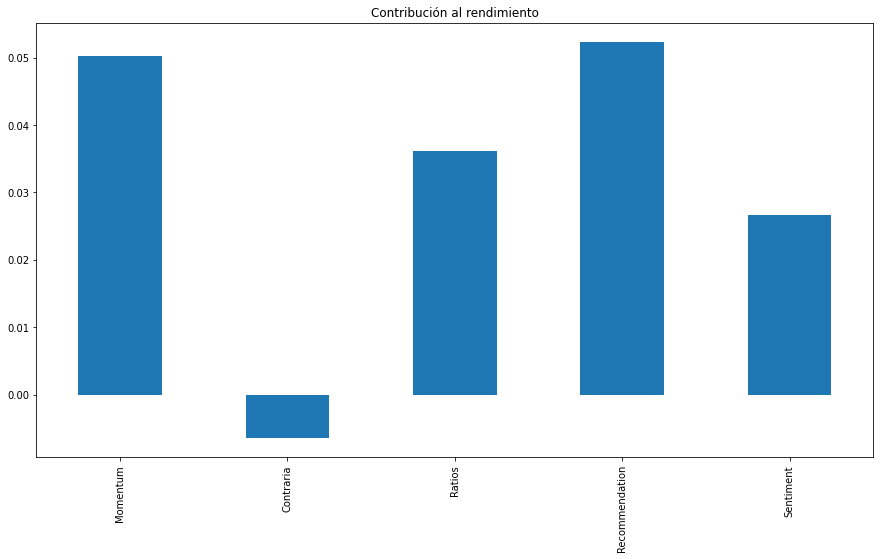

In [51]:
rendimiento.Rendimiento.plot.bar(title = "Contribución al rendimiento", figsize = (15, 8))

## Generación de la cartera

A continuación, se incluyen una serie de funciones para calcular el rendimiento anualizado del portfolio, la desviación estandar anualizada del portfolio (el riesgo), el ratio de Sharp, donde podemos alterad el rendimiento deseado (en este caso se ha seleccionado 0.15, aunque no es muy alto, porque era el valor máximo de rendimiento con el cual se mantenía positivo el ratio de Sharpe), los portfolios aleatorios para graficar y la tangente con la frontera eficiente.

In [63]:
def mu(w,r):
    '''Rendimiento portfolio anualizado'''
    return sum(w * r * 252) 


def sigma(w, C):
    '''Desv STD portadolio anualizada'''
    return np.dot(w,np.dot(C,w.T)) ** (1/2) * 252 ** (1/2)


def sharpe(w):
    '''Sharpe ratio con rf de 10%'''
    '''CAMBIAR RENDIMIENTO AQUI'''
    rf = .15
    return (mu(w,r) - rf) / sigma(w,C)


def neg_sharpe(w):
    '''Sharpe ratio negativo'''
    return -sharpe(w)


def random_ports(n):
    '''Portfolios aleatorios'''
    means, stds = [],[]
    for i in range(n):
        rand_w = np.random.rand(len(df.columns))
        rand_w = rand_w / sum(rand_w)
        means.append(mu(rand_w, r))
        stds.append(sigma(rand_w,C))
    
    return means, stds

In [65]:
np.random.rand(len(df.columns))

array([0.85612538, 0.08771606, 0.43621014, 0.18735317, 0.49418432])

Un portafolio "Equally weighted" tendría un Sharpe Ratio de:

In [66]:
print("Sharpe port equal w:", round(sharpe(w),2))

Sharpe port equal w: 0.05


Con el código a continuación, generamos los pesos óptimos de nuestra cartera, donde podemos indicar si solicitaoms pesos mínimos o máximos para cualquiera de las acciones incluidas en nuestra cartera. En este caso, se selecciona que haya al menos un 5% de representación de cada acción en la cartera total, pues si no se selecciona un mínimo, la función elige invertir unicamente en dos de ellas y deseamos que esté diversificada. Además, incluimos también un máximo, para que no haya tanto desbalanceo, pero de todas formas hay dos estrategias principales con mayor peso (las que tienen mayor riesgo pero mayor rentabilidad: momentum y recomendación).

En el resumen a continuación, al final del todo, nombrados con una x, vemos la selección de pesos óptimos que ha realizado la función con los parámetros introducidos:[0.35, 0.05, 0.05, 0.5 , 0.05])

In [68]:
import scipy.optimize as optimize

def apply_sum_constraint(inputs):
    total = 1 - np.sum(inputs)
    return total

my_constraints = ({'type': 'eq', "fun": apply_sum_constraint })


result = optimize.minimize(neg_sharpe, 
                      w,
                      method='SLSQP', 
                      bounds=((0.05, 0.5), (0.05, 0.5), (0.05, 0.5), (0.05, 0.5), (0.05, 0.5)),
                      options={'disp': True},
                      constraints=my_constraints)
print(result)
optimal_w = result["x"]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.14571119531418003
            Iterations: 6
            Function evaluations: 42
            Gradient evaluations: 6
     fun: -0.14571119531418003
     jac: array([-0.91920065,  0.50992162, -0.74399857, -0.92893246, -0.59972947])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.35, 0.05, 0.05, 0.5 , 0.05])


Por último, generamos un gráfico que muestre 10000 las carteras aleatorias generadas, que seleccione la que considera la mejor (en base a un rendimiento y riesgo óptimos que observamos sobre el gráfico) y muestre la frontera eficiente.

El rendimiento de la cartera óptima es 0.176 y su volatilidad es 0.181


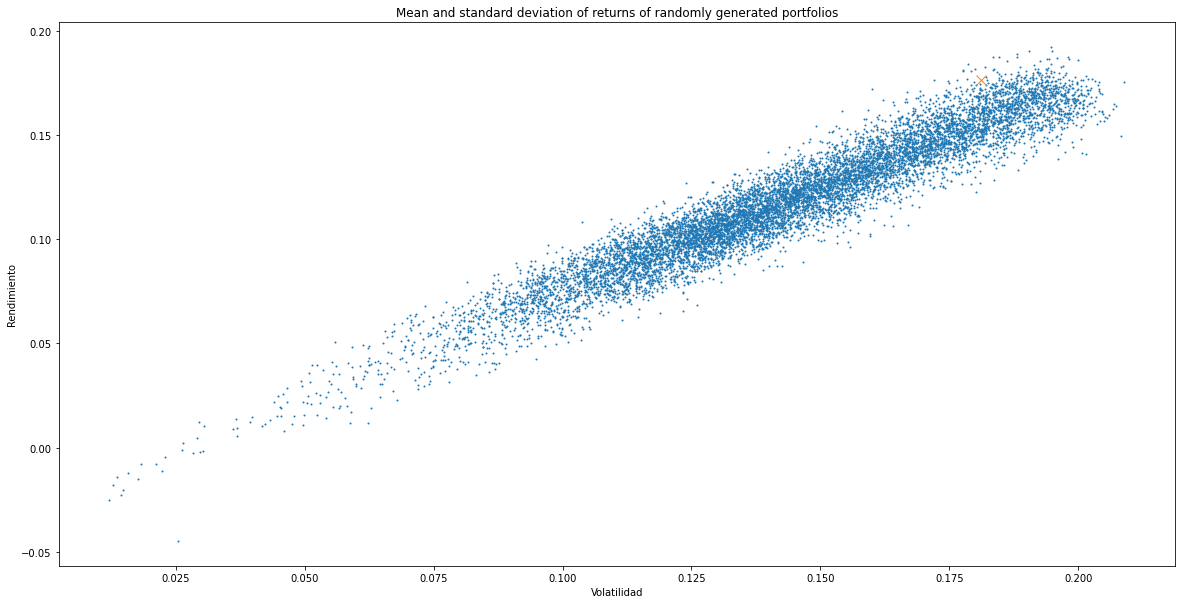

In [69]:
#Grafiquemos
n_portfolios = 10000   # generamos 10000 carteras aleatorias
means, stds = random_ports(n_portfolios) # generamos rendimientos y riesgos aleatorios

best_mu = mu(optimal_w, r) 
best_sigma = sigma(optimal_w, C)
best_sharpe = sharpe(optimal_w) ## la mejor cartera se seleccionara en base a los pesos óptimos, los renidmientos y el riesgo
# introducidos anteriormente
plt.figure(figsize=(20,10))
plt.plot(stds, means, 'o', markersize=1)
plt.plot(best_sigma, best_mu, 'x',  markersize=10)
plt.xlabel('Volatilidad')
plt.ylabel('Rendimiento')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
print('El rendimiento de la cartera óptima es', round(best_mu, 3), 'y su volatilidad es', round(best_sigma, 3))

## Correlaciones con modelos de regresión.

Para terminar el estudio, creamos una nueva variable con la cartera final aplicando la combinación de todas las estrategias en base a los pesos óptimos y la comparamos con ellas.

In [57]:
cartera = datos*optimal_w
cartera['Cartera Final'] = cartera.sum(axis = 1)
cartera

,Momentum,Contraria,Ratios,Recommendation,Sentiment,Cartera Final
Date,,,,,,
2015-01-05,50.000000,5.000000,5.000000,35.000000,5.000000,100.000000
2015-01-06,49.770039,5.014159,4.970002,34.771593,4.978446,99.504240
2015-01-07,50.426160,4.977881,5.039754,35.360150,5.040304,100.844249
2015-01-08,52.194052,4.903606,5.260405,36.798711,5.283390,104.440164
2015-01-09,51.382542,4.939941,5.157936,36.078360,5.172581,102.731360
...,...,...,...,...,...,...
2019-12-25,124.315473,2.890585,10.476861,87.566937,9.100712,234.350568
2019-12-26,124.627663,2.887157,10.507018,87.809546,9.120375,234.951759
2019-12-27,125.063854,2.881534,10.559272,87.860839,9.163358,235.528857


En la tabla a continuación, se puede observar la correlación existente entre nuestra cartera generada y cada estrategia. Observamos que la mayor correlación a la cartera final es con la estrategia de recomendación que, anteriormente, se había analizado como la más rentable pero también la más volátil, y que es la que más peso tiene en la cartera. Cabe mencionar también que la menor correlación es con la estrategia de sentimiento, a pesar de que tiene la misma representación en nuestra cartera óptima que las de correlación y de ratios. El resto de correlaciones son muy altas (superiores al 97%) y muy similares.

In [70]:
correlaciones = cartera.corr()
correlaciones['Cartera Final']

Momentum          0.998609
Contraria        -0.978931
Ratios            0.994423
Recommendation    0.998220
Sentiment         0.932196
Cartera Final     1.000000
Name: Cartera Final, dtype: float64

Para finalizar estas comparaciones y el análisis de correlación, graficamos la cartera generada en comparación con las tres estrategias con las que mayor correlación coparte y que mayor peso tienen en su generación:

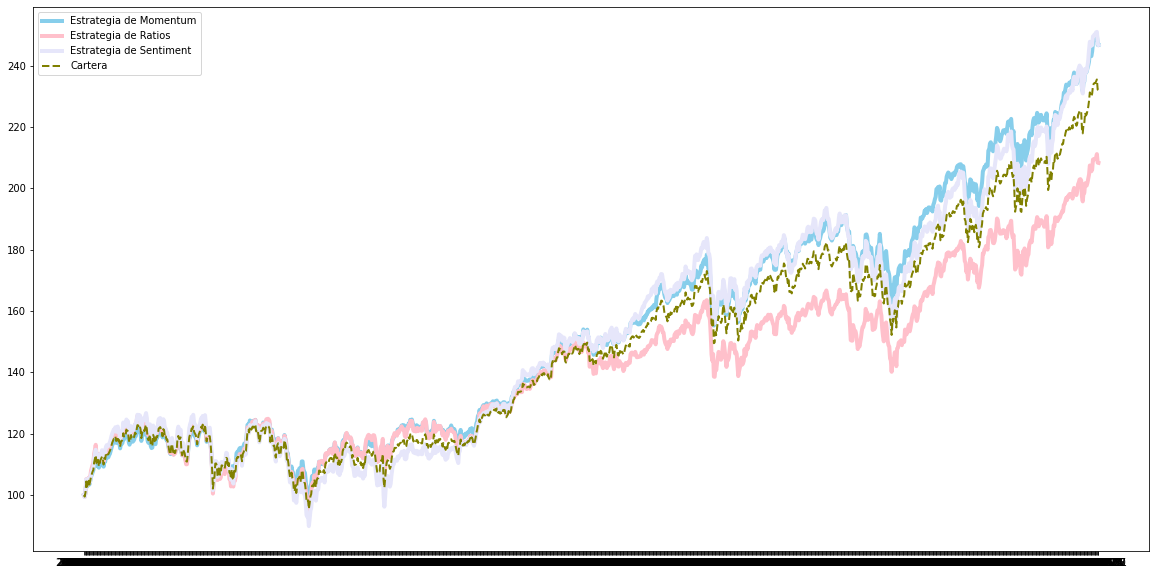

In [73]:
plt.figure(figsize=(20,10))
plt.plot(datos.index, datos['Momentum'], marker='', markerfacecolor='blue', markersize=12, color='skyblue', 
         linewidth=4, label = 'Estrategia de Momentum')
plt.plot(datos.index, datos['Ratios'], marker='', markerfacecolor='pink', markersize=12, color='pink', 
         linewidth=4, label = 'Estrategia de Ratios')
plt.plot(datos.index, datos['Recommendation'], marker='', markerfacecolor='lavender', markersize=12, color='lavender', 
         linewidth=4, label = 'Estrategia de Sentiment')
plt.plot(cartera.index, cartera['Cartera Final'], marker='', color='olive', linewidth=2, linestyle='dashed', label="Cartera")
plt.legend()

## Conclusiones sobre la metodología

Podemos concluir lo siguiente: 
* Todas las estrategias siguen una tendencia de crecimiento (a excepción de la opuesta) muy similar debido a los pesos seleccionados para cada una.
* La cartera generada es menos rentable pero también menos volátil que las estrategias que la componen principalmente, debido probablemente al componente de la estrategia contraria.
* La cartera final es capaz de aumentar sus beneficios por más del doble del valor inicial (empieza con 100€ de inversión y finaliza con unos 230€) 
* Existen muchos picos y muchas caidas marcadas en las estrategias alcistas.
* Con una mayor cantidad de activos a comparar, obtendríamos resultados más precisos.

Cabe mencionar que la metodología de combinar varias estrategias con procedimientos completamente distintos resulta ser muy positiva a la hora de diversificar la cartera y protegerse frente un mercado muy volátil. Al tene en cuenta factores como rentabilidad propia de la empresa en distintos periodos de tiempo, ratios de rendimiento y perspectivas externas a la empresa (como análisis de sentimiento y recomendaciones de analistas), el estudio es muy amplio y se cubren aspectos tanto externos como internos. Esto permite que la cartera en cuestión esté preparada para asumir riesgos de ambos ámbitos.

## Ventajas y desventajas de cada modelo aplicado.

* __Cross sectional momentum__: Esta estrategia, aunque muy volátil, aporta el segundo mayor rendimiento de todas. Los pesos son muy fáciles de seleccionar, aunque se debe tener en cuenta el resultado (prueba y error, más eficiente si se hiciera ocn train y test). Además, se tienen en cuenta muchas rentabilidades distintas a distintos plazos que permiten especificar más la importancia del corto y largo plazo según los activos que aportan mayor rendimiento en uno u otro. Esta estrategia, junto con la contraria, muestran un estudio principalmente interior de cada empresa.
* __Contraria__: En cuanto al funcionamiento o selección de pesos, es prácticamente igual que la estrategia anterior. La pega principal es que, en el largo y corto plazo, esta estrategia siempre pierde. Sin embargo, al ser mucho más estable que las demás, no sufre pérdidas tan pronunciadas y resulta ser mucho más estable. Esto es importante porque, en caso de generarse un impacto negativo muy grave en la economía (como puede ser el del COVID 19), la pérdida de esta estrategia jamás será de la magnitud que sufrirían las demás estrategias (mucho más volátiles).
* __Ratios__: en las ventajas, cabe destacar que permite obtener información adicional de las empresas, además que no se ciñe al valor de mercado. También aporta una visión gobal de cada compañía al comparar ratios muy distintos y mide criterios objetivos (como los flujos de caja o la solvencia). Por otro lado, en cuanto a las desventajas podemos añadir que si no se actualizan los ratios, no tiene sentido establecer una estrategia de ratios a lo largo del tiempo con los ratios de un momento puntual. Además, no aportan una ventaja competitiva frente al resto y se genera mal comportamiento con variaciones macroeconómicas grandes. Por último, en cuanto a la relación entre volatilidad y rentabilidad, es muy similar a la de la estrategia de momentum y las dos siguientes.
* __Sentimiento__: Las ventajas del analisis de sentimiento son que pueden hacerse recogidas de información de las compañías y la valoración de la sociedad por diversos canales, a través de redes sociales com twitter, facebook, también noticias de periódicos. Otra ventaja es que pueden hacerse análisis originales, distintos a todos los indicadores que tienen el resto de competidores, lo que puede aportar ventajes frente a los mismos. Como desventaja está que debe hacerse un analisis de sentimiento de las compañías en periodos cortos de tiempo, ya que son aspectos muy cambiantes. Se ha cimprobafo además que el sentimiento que una compañía despierta en twitter o distintas redes sociales no suele afectar en exceso a su comportamiento en bolsa, salvo que implique a persomajes públicos notorios como el caso de Donald Trump.
* __Recomendaciones de analistas__: Ventajas: que es recogida de informacion de expertos y hay muchos de ellos. Aportanfo informqción más allá de los criterios objetivos del mercado. Además, se pueden obtener rentabilidades anormales significativas siguiendo las recomendaciones de los analistas, aunque son más evidentes las ganancias asociadas a los cambios de las recomendaciones. Por otra parte, se aporta evidencia a favor de que las recomendaciones y cambios en las mismas emitidos por las agencias de valores también tienen influencia sobre el precio de los activos. Como desventaja mencionar que pueden diferir mucho unos de otro en opiniones, por lo que es importante saber cuáles se comportan mejor, hacer un seguimiento exahustivo de los mismo además de las compañías

__Bibliografía:__

* https://www.linkedin.com/pulse/frontera-eficiente-en-python-oscar-rojas-cfa
* http://amarjen.github.io/dibujar-frontera-eficiente.html#.XqR0ImgzZPY